# Impor Libraries

In [1]:
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import plot_roc_curve, cal_acc_pres_f1

c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#FIXME: el edge (1,2) es equivalente a (2,1)), es importante asegurarse de que ambos casos se asignen al mismo conjunto (entrenamiento, validación o prueba). La implementación actual, sin embargo, no garantiza esto.
#FIXME: Entrenamiento con unicamente nodos, areglar varanza (long tail) y normalizar 
#FIXME: porq me esta dando la validacion eso, ver ambos lados como se infieren???

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

Done loading data from cached files.
None
Training edges: 259719
Validation edges: 86890
Test edges: 87370
In epoch 0, loss: 1.7933095693588257, train acc: 0.2769647240638733, val acc: 0.2762688398361206
In epoch 10, loss: 0.699367105960846, train acc: 0.37996065616607666, val acc: 0.37918058037757874
In epoch 20, loss: 0.6840803027153015, train acc: 0.5584881901741028, val acc: 0.5613073706626892
In epoch 30, loss: 0.6820834875106812, train acc: 0.5511494874954224, val acc: 0.5522269606590271
In epoch 40, loss: 0.6655235886573792, train acc: 0.4015917181968689, val acc: 0.40206006169319153
In epoch 50, loss: 0.6285502314567566, train acc: 0.5898721218109131, val acc: 0.5930026173591614
In epoch 60, loss: 0.617058515548706, train acc: 0.5981233716011047, val acc: 0.6004948616027832
In epoch 70, loss: 0.6007592082023621, train acc: 0.6405807733535767, val acc: 0.6429508328437805
In epoch 80, loss: 0.5762108564376831, train acc: 0.6830767393112183, val acc: 0.6826562285423279
In epoch 90

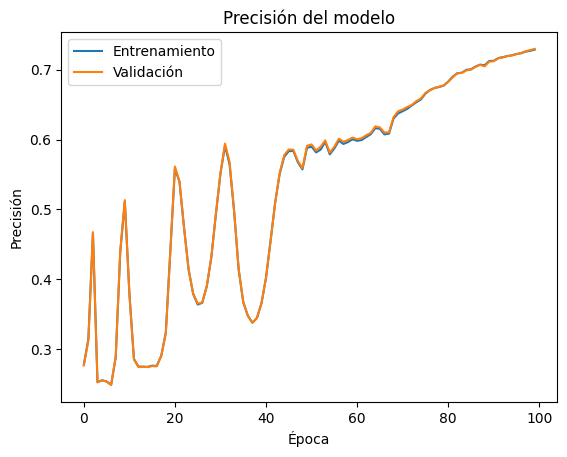

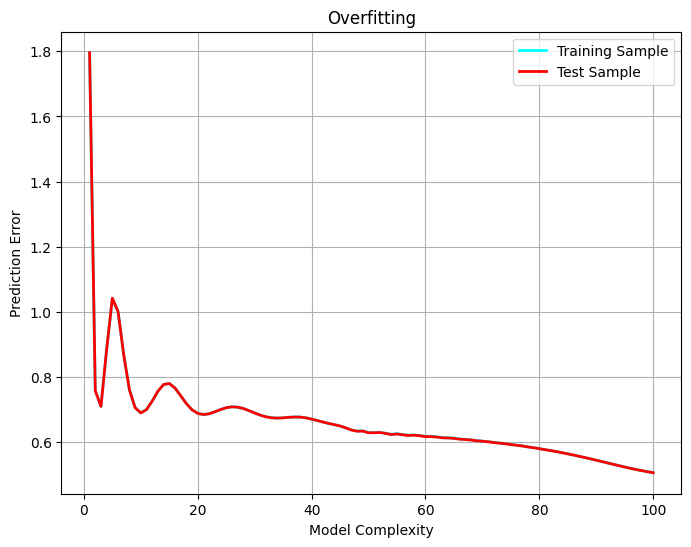

In [15]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
# gnn.split_dataset()
gnn.split_dtaset_v2()



gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])
  train_error.append(loss.item())

  # Calcular la pérdida en el conjunto de validación
  val_loss = F.binary_cross_entropy_with_logits(scores[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Guardar la complejidad del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)
  
  # Convertir los logits en predicciones binarias (0 o 1)
  preds = torch.sigmoid(scores) > 0.5

  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = (preds[train_mask] == labels[train_mask]).float().mean().item()

  # Calcular la precisión en el conjunto de validación
  val_acc = (preds[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}, train acc: {}, val acc: {}'.format(e, loss,train_acc,val_acc))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

# Graficar la precisión en el conjunto de entrenamiento y validación
plt.figure()
plt.plot(acc_train, label='Entrenamiento')
plt.plot(acc_val, label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

# Graficar Error en el conjunto de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(model_complexity, train_error, label='Training Sample', color='cyan', linewidth=2)
plt.plot(model_complexity, val_error, label='Test Sample', color='red', linewidth=2)
plt.xlabel('Model Complexity')
plt.ylabel('Prediction Error')
plt.title('Overfitting')
plt.legend()
plt.grid(True)
plt.show()


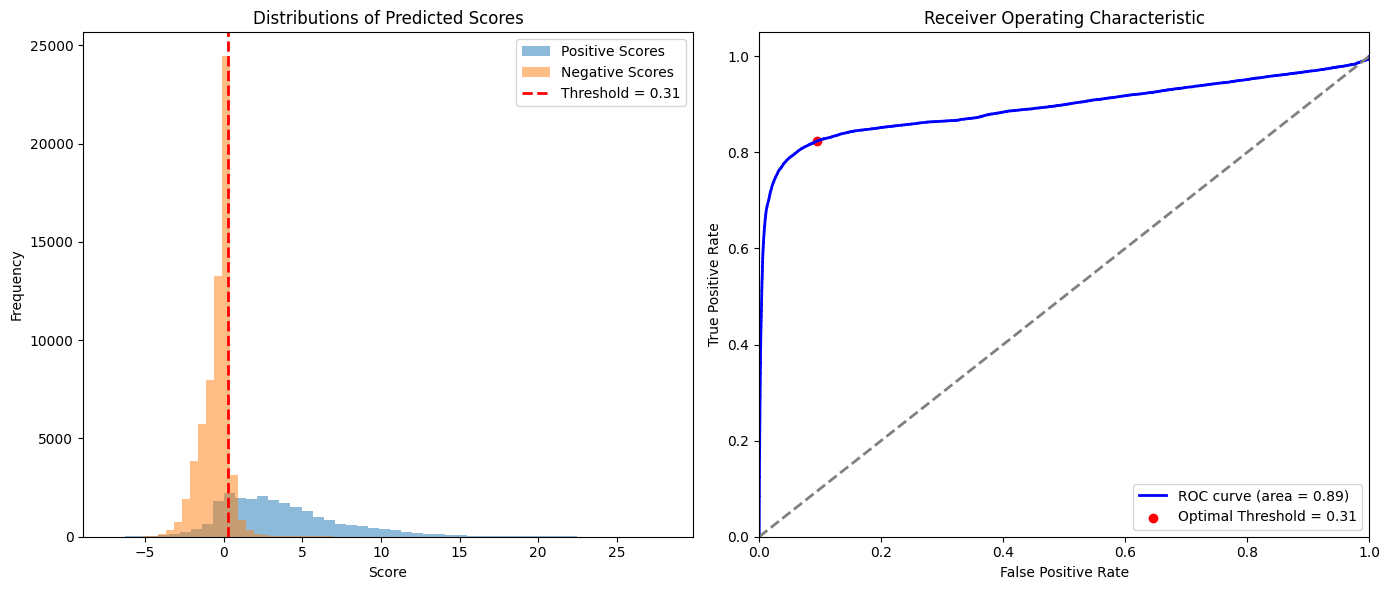

AUC: 0.8936073947204897
CALCULO
IF
ACCURACY 0.8828201899965663
PRESICION 0.7673202107873528
RECALL 0.823889166250624
F1 SCORE 0.7945991493459593
Classification Report:

              precision    recall  f1-score   support

           0     0.9312    0.9052    0.9180     63334
           1     0.7673    0.8239    0.7946     24036

    accuracy                         0.8828     87370
   macro avg     0.8493    0.8645    0.8563     87370
weighted avg     0.8861    0.8828    0.8841     87370



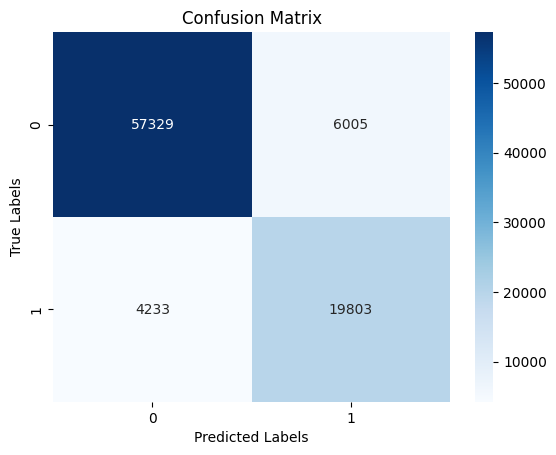

In [16]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : ALL
    * Predictor : MLPPredictor
    

Done loading data from cached files.
None
Training edges: 260374
Validation edges: 86902
Test edges: 86703
In epoch 0, loss: 0.6370319128036499
In epoch 10, loss: 0.3859872817993164
In epoch 20, loss: 0.20807592570781708
In epoch 30, loss: 0.17301709949970245
In epoch 40, loss: 0.14883410930633545
In epoch 50, loss: 0.1358216553926468
In epoch 60, loss: 0.12663204967975616
In epoch 70, loss: 0.11976397782564163


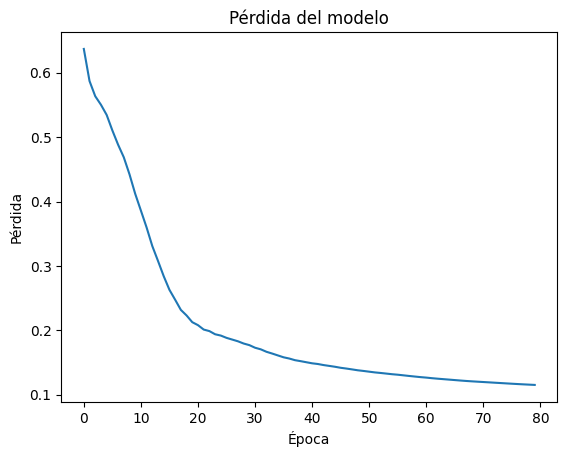

In [17]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()



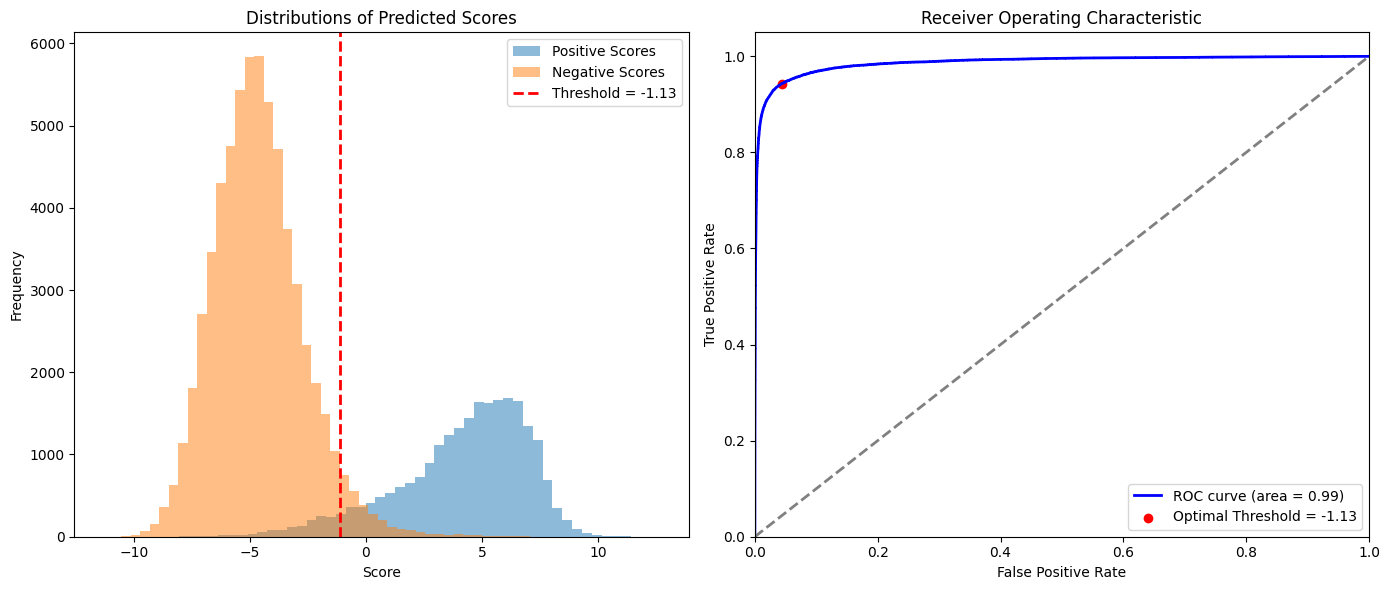

AUC: 0.9866448506692442
CALCULO
IF
ACCURACY 0.9527928676055039
PRESICION 0.8919817857849931
RECALL 0.9428679055750879
F1 SCORE 0.9167192300649074
Classification Report:

              precision    recall  f1-score   support

           0     0.9778    0.9566    0.9671     62811
           1     0.8920    0.9429    0.9167     23892

    accuracy                         0.9528     86703
   macro avg     0.9349    0.9497    0.9419     86703
weighted avg     0.9541    0.9528    0.9532     86703



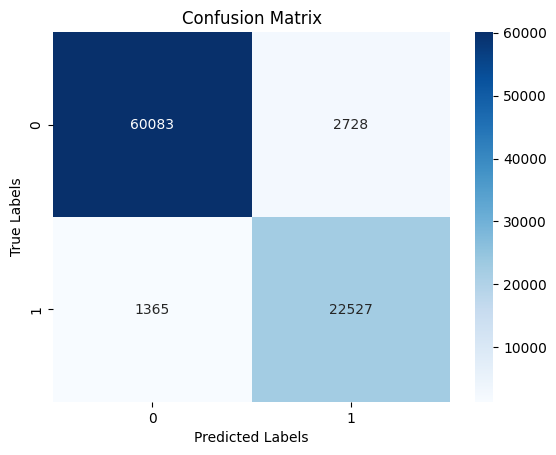

In [18]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor
    

In [3]:
# Crear dataset
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """
import os
from modules.graph import Graph

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[SAVE : c:\Users\Vale\Desktop\GIT\TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/edges.csv]
DiGraph with 74145 nodes and 461889 edges
[SAVE IN: c:\Users\Vale\Desktop\GIT\TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/nodes.csv]
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260033
Validation edges: 86837
Test edges: 87109
tensor([[10.,  7.],
        [15.,  3.],
        [21.,  2.],
        ...,
        [ 2.,  0.],
        [ 2., 12.],
        [ 1.,  0.]])
In epoch 0, loss: 2099806.5
In epoch 10, loss: 75977.6796875
In epoch 20, loss: 85854.5625
In epoch 30, loss: 48013.453125
In epoch 40, loss: 13836.9736328125
In epoch 50, loss: 16644.841796875
In epoch 60, loss: 10550.51953125
In epoch 70, loss: 9283.1884765625
In epoch 80, loss: 7290.1474609375
In epoch 90, loss: 6006.67822265625
In epoch 100, loss: 4942.32275390625
In epoch 110, loss: 4126.5791015625
In epoch 120, loss: 3561.60302734375
In epoch 130, loss: 3100.299072265625
In epoch 140, loss: 2703.16552734375
In epoch 150, loss: 2367.98681640625
In epoch 160, loss: 2079.626953125
In epoch 170, loss: 1824.2957763671875
In epoch 180, loss: 1599.916015625
In epoch 190, loss: 1422.27587890625


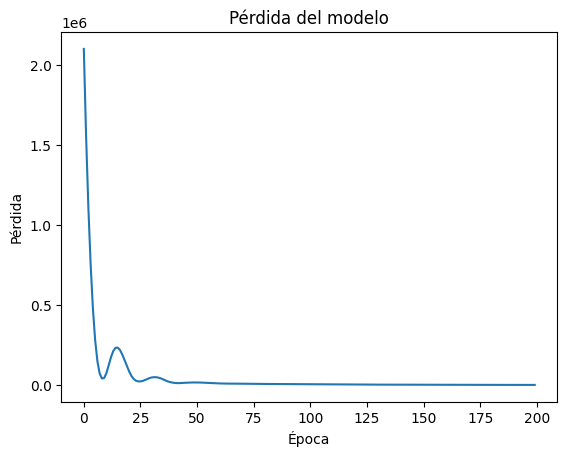

In [8]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(200):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()



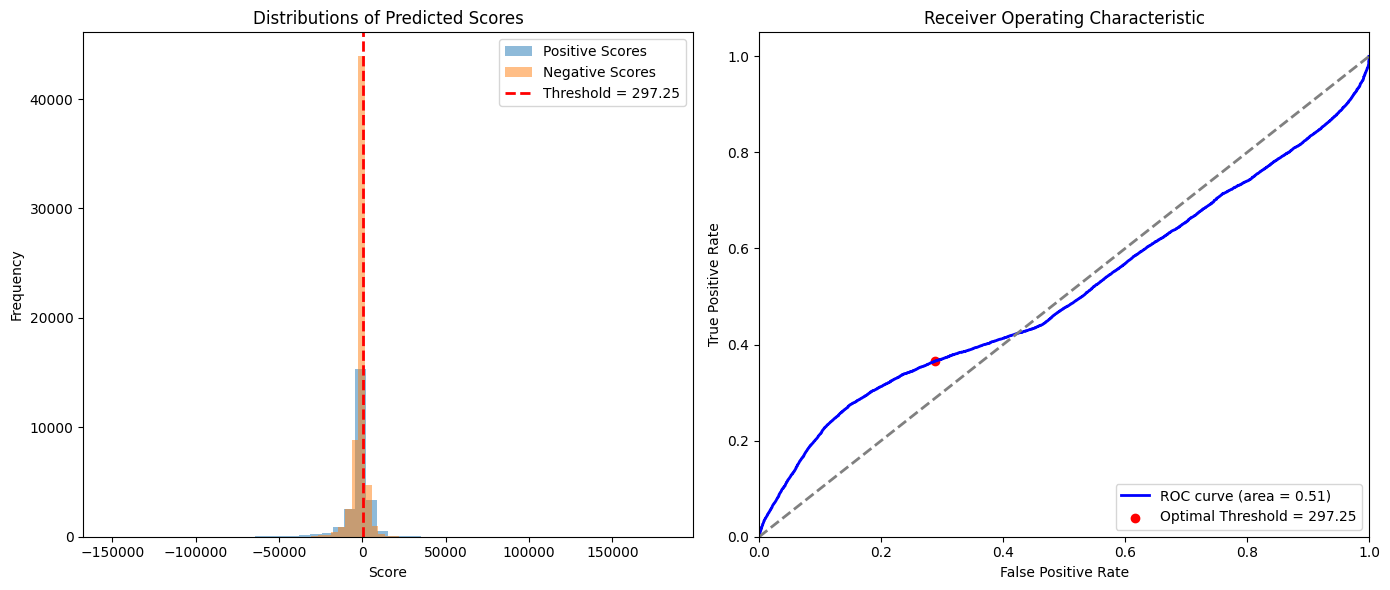

AUC: 0.5074387418753828
CALCULO
IF
ACCURACY 0.6170906793774766
PRESICION 0.324595649749024
RECALL 0.3652261222440698
F1 SCORE 0.34371431946139613
Classification Report:

              precision    recall  f1-score   support

           0     0.7478    0.7124    0.7297     63162
           1     0.3246    0.3652    0.3437     23903

    accuracy                         0.6171     87065
   macro avg     0.5362    0.5388    0.5367     87065
weighted avg     0.6316    0.6171    0.6237     87065



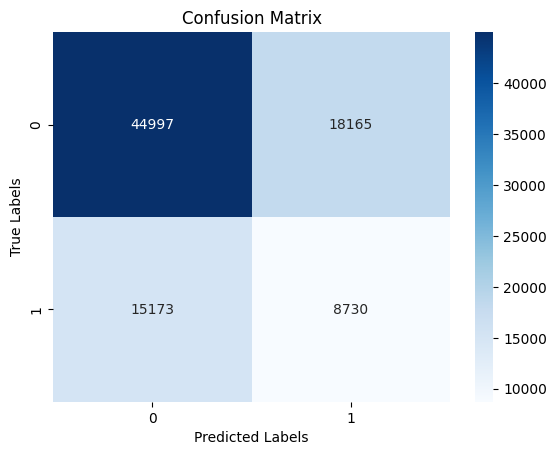

In [7]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [21]:
from modules.graph import *
LIST_FEATURES_CATEG = ['AS_rank_continent',
                        'peeringDB_info_ratio',
                        'peeringDB_info_scope',
                        'peeringDB_info_type',
                        'peeringDB_policy_general'
                        'ASDB_C1L1']

# Crear Di graph 
list_feat = ['AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']  +  LIST_FEATURES_CATEG
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[SAVE : c:\Users\Vale\Desktop\GIT\TESIS/datasets/DGL_Graph/MYCODEDiGraph/edges.csv]
DiGraph with 74145 nodes and 461889 edges
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260399
Validation edges: 86746
Test edges: 86834
In epoch 0, loss: 0.6402365565299988
In epoch 10, loss: 0.4430164396762848
In epoch 20, loss: 0.24713999032974243
In epoch 30, loss: 0.188919797539711
In epoch 40, loss: 0.15580296516418457
In epoch 50, loss: 0.140705406665802
In epoch 60, loss: 0.1317654848098755
In epoch 70, loss: 0.12630118429660797


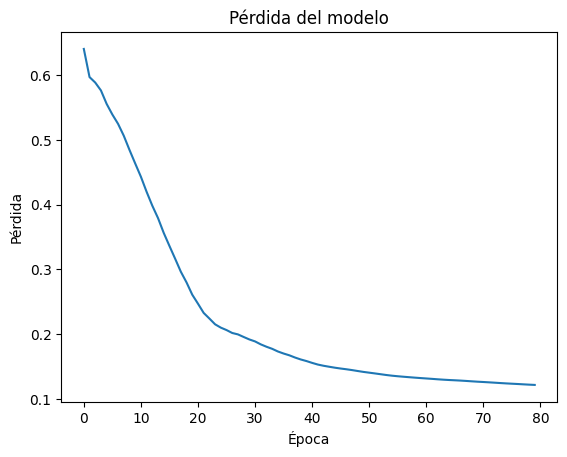

In [22]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


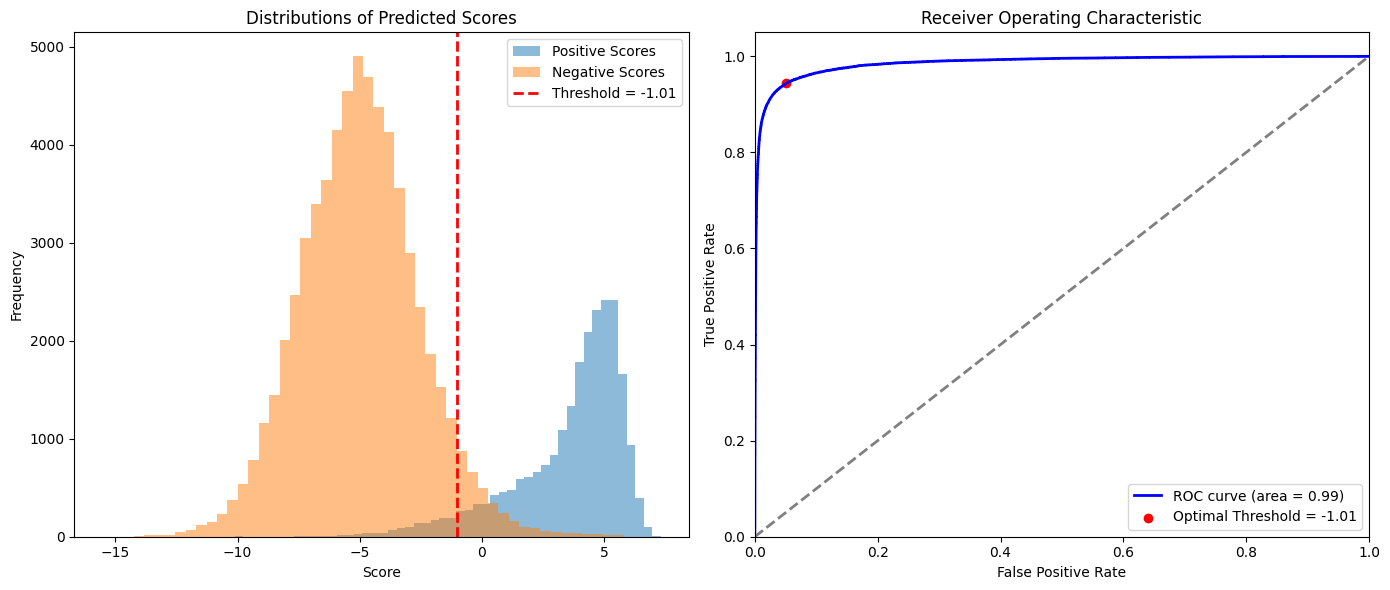

AUC: 0.9857312303481655
CALCULO
IF
ACCURACY 0.9479005919340351
PRESICION 0.8762561346108904
RECALL 0.9435078007045797
F1 SCORE 0.9086392826850842
Classification Report:

              precision    recall  f1-score   support

           0     0.9780    0.9496    0.9636     62990
           1     0.8763    0.9435    0.9086     23844

    accuracy                         0.9479     86834
   macro avg     0.9271    0.9465    0.9361     86834
weighted avg     0.9500    0.9479    0.9485     86834



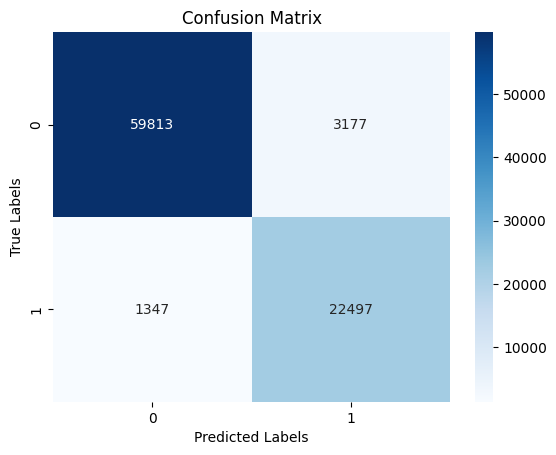

In [23]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)